In [1]:
suppressMessages(library(ArchR))
ss <- function(x, pattern, slot = 1, ...) { sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)
suppressMessages(library(Seurat))
suppressMessages(library(tidyverse))
suppressMessages(library(SingleCellExperiment))

Warning message:
“package ‘gtable’ was built under R version 4.1.3”
Warning message:
“package ‘magrittr’ was built under R version 4.1.3”
Warning message:
“package ‘plyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning message:
“package ‘data.table’ was built under R version 4.1.3”
Warning message:
“package ‘Matrix’ was built under R version 4.1.3”
Warning message:
“package ‘Rcpp’ was built under R version 4.1.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”


In [2]:
##################################
### set Arrow File parameters ####
addArchRThreads(threads = 12)

##################################
### load rheMac10 ArchR genome ###
GENOMEDIR='/home/bnphan/resources/genomes/rheMac10'
load(file.path(GENOMEDIR,'rheMac10_liftoff_GRCh38.p13_ArchR_annotations.rda'))

Setting default number of Parallel threads to 12.



In [3]:
PROJDIR='../../../data/tidy_data/ArchRProjects'
proj = loadArchRProject(file.path(PROJDIR,'Rat_Transgen_NAc_scATAC'), showLogo = FALSE)
projMSN = loadArchRProject(file.path(PROJDIR,'Rat_Transgen_NAc_scATAC_MSN'), showLogo = FALSE)
projNeuron = loadArchRProject(file.path(PROJDIR,'Rat_Transgen_NAc_scATAC_Neuron'), showLogo = FALSE)
projGlia = loadArchRProject(file.path(PROJDIR,'Rat_Transgen_NAc_scATAC_Glia'), showLogo = FALSE)

Successfully loaded ArchRProject!

Successfully loaded ArchRProject!

Successfully loaded ArchRProject!

Successfully loaded ArchRProject!



In [4]:
getCellColData(proj)

DataFrame with 26261 rows and 20 columns
                           Sample TSSEnrichment ReadsInTSS ReadsInPromoter
                      <character>     <numeric>  <numeric>       <numeric>
1S#AGAAGGTGTTGTTCAC-1          1S         3.581       1152           10361
1S#AAGCCTGTCTTAGGGT-1          1S         3.240       1170           10461
1S#ACTTGAATCGGTTCCT-1          1S         4.230       1598           12207
1S#GGCTTCAAGCAAACCT-1          1S         3.023        974            9403
1S#TCACTGACAACTGGCT-1          1S         3.668       1267           10649
...                           ...           ...        ...             ...
5M#TCCAGGATCCTGGTGA-1          5M         8.641        144             844
5M#CGTGACATCTTACTCG-1          5M         6.450        114             692
5M#GGTGTGACATTAGCCA-1          5M         4.408         69             547
5M#TTTGTTGGTGGTTCTT-1          5M         7.178        116             663
5M#ATGCGATTCACAAGCT-1          5M        16.304        247 

# Add integrated labels from subclustering

In [11]:
df_MSN = getCellColData(projMSN) %>% as.data.frame() %>% rownames_to_column('Barcode')
df_Neuron = getCellColData(projNeuron) %>% as.data.frame() %>% rownames_to_column('Barcode') %>% 
    filter(Barcode %ni% df_MSN$Barcode)
df_Glia = getCellColData(projGlia) %>% as.data.frame() %>% rownames_to_column('Barcode')

df_label = data.table::rbindlist(list(df_MSN, df_Neuron, df_Glia), fill = TRUE) %>% 
    mutate(cluster_rat_RNA2ATAC = ifelse(!is.na(cluster_rat_RNA2ATAC), cluster_rat_RNA2ATAC, cluster_rat), 
          cluster_macaque_RNA2ATAC = ifelse(!is.na(cluster_macaque), cluster_macaque, Celltype1))

table(df_label$cluster_rat_RNA2ATAC)
table(df_label$cluster_macaque_RNA2ATAC)
class(df_label$Barcode)
class(df_label$cluster_macaque_RNA2ATAC)


df_label = df_label[df_label$Barcode %in% proj$cellNames]


      Astrocytes       D1-ICj-MSN           D1-MSN     D1-NUDAP-MSN 
             899              419             2173              501 
D1/D2-Hybrid-MSN        D1/D3-MSN           D2-MSN        Microglia 
             607              893             2478              527 
          Oligos       Oligos_Pre        Pvalb-INT          Sst-INT 
            1416              942               78              102 


       Astro D1.D2.Hybrid       D1.ICj     D1.NUDAP     D1.Shell     D2.Shell 
        1151          607          419          501         3066         2478 
Interneurons    Microglia       Neuron        Oligo          OPC 
         180         1109        14199         2392         1483 

[1] "character"

[1] "character"

In [12]:
## transfer labels via cell barcodes
proj <- addCellColData(ArchRProj = proj, data = df_label$cluster_rat_RNA2ATAC,
    cells = df_label$Barcode, name = "cluster_rat_RNA2ATAC", force = TRUE)

proj <- addCellColData(ArchRProj = proj, data = df_label$cluster_macaque_RNA2ATAC,
    cells = df_label$Barcode, name = "cluster_macaque_RNA2ATAC", force = TRUE)

idxSample <- BiocGenerics::which(!is.na(proj$cluster_rat_RNA2ATAC) & 
                                !is.na(proj$cluster_macaque_RNA2ATAC))

In [13]:
length(idxSample)
cellsSample <- proj$cellNames[idxSample]
proj = subsetCells(ArchRProj = proj, cellNames = cellsSample)

table(proj$cluster_rat_RNA2ATAC)
table(proj$cluster_macaque_RNA2ATAC)
getCellColData(proj)

[1] 10959


      Astrocytes       D1-ICj-MSN           D1-MSN     D1-NUDAP-MSN 
             898              414             2165              495 
D1/D2-Hybrid-MSN        D1/D3-MSN           D2-MSN        Microglia 
             604              870             2461              525 
          Oligos       Oligos_Pre        Pvalb-INT          Sst-INT 
            1416              942               73               96 


       Astro D1.D2.Hybrid       D1.ICj     D1.NUDAP     D1.Shell     D2.Shell 
         898          604          414          495         3035         2461 
Interneurons    Microglia        Oligo          OPC 
         169          525         1416          942 

DataFrame with 10959 rows and 22 columns
                           Sample TSSEnrichment ReadsInTSS ReadsInPromoter
                      <character>     <numeric>  <numeric>       <numeric>
1S#TTGTGCCTCCTGTTCA-1          1S         4.660        913            6950
1S#AAGTTTGTCACCATTT-1          1S         3.868        840            6645
1S#AGGTCCGGTATCTGGA-1          1S         4.541        892            6618
1S#GCCTATTGTGTGTCCC-1          1S         4.270        856            6571
1S#GGTTTAATCCAGGTTG-1          1S         4.365        853            6508
...                           ...           ...        ...             ...
5M#ATGTCCACAACCCTAA-1          5M        13.340        256            1228
5M#TCCAGGATCCTGGTGA-1          5M         8.641        144             844
5M#CGTGACATCTTACTCG-1          5M         6.450        114             692
5M#GGTGTGACATTAGCCA-1          5M         4.408         69             547
5M#ATGCGATTCACAAGCT-1          5M        16.304        247 

In [16]:
proj = subsetArchRProject( proj, outputDirectory = file.path(PROJDIR,'Rat_Transgen_NAc_scATAC2'), force = TRUE)

Copying ArchRProject to new outputDirectory : /projects/pfenninggroup/singleCell/Pierce_transgen_rat_multiome/data/tidy_data/ArchRProjects/Rat_Transgen_NAc_scATAC2

Copying Arrow Files...

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 2): Embeddings

Copying Other Files (2 of 2): IterativeLSI200_ATAC

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==..

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-2632c32406918-Date-2022-12-05_Time-14-52-34.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-2632c32406918-Date-2022-12-05_Time-14-52-34.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-2632c4886f117-Date-2022-12-05_Time-14-52-34.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-2632c4886f117-Date-2022-12-05_Time-14-52-34.log



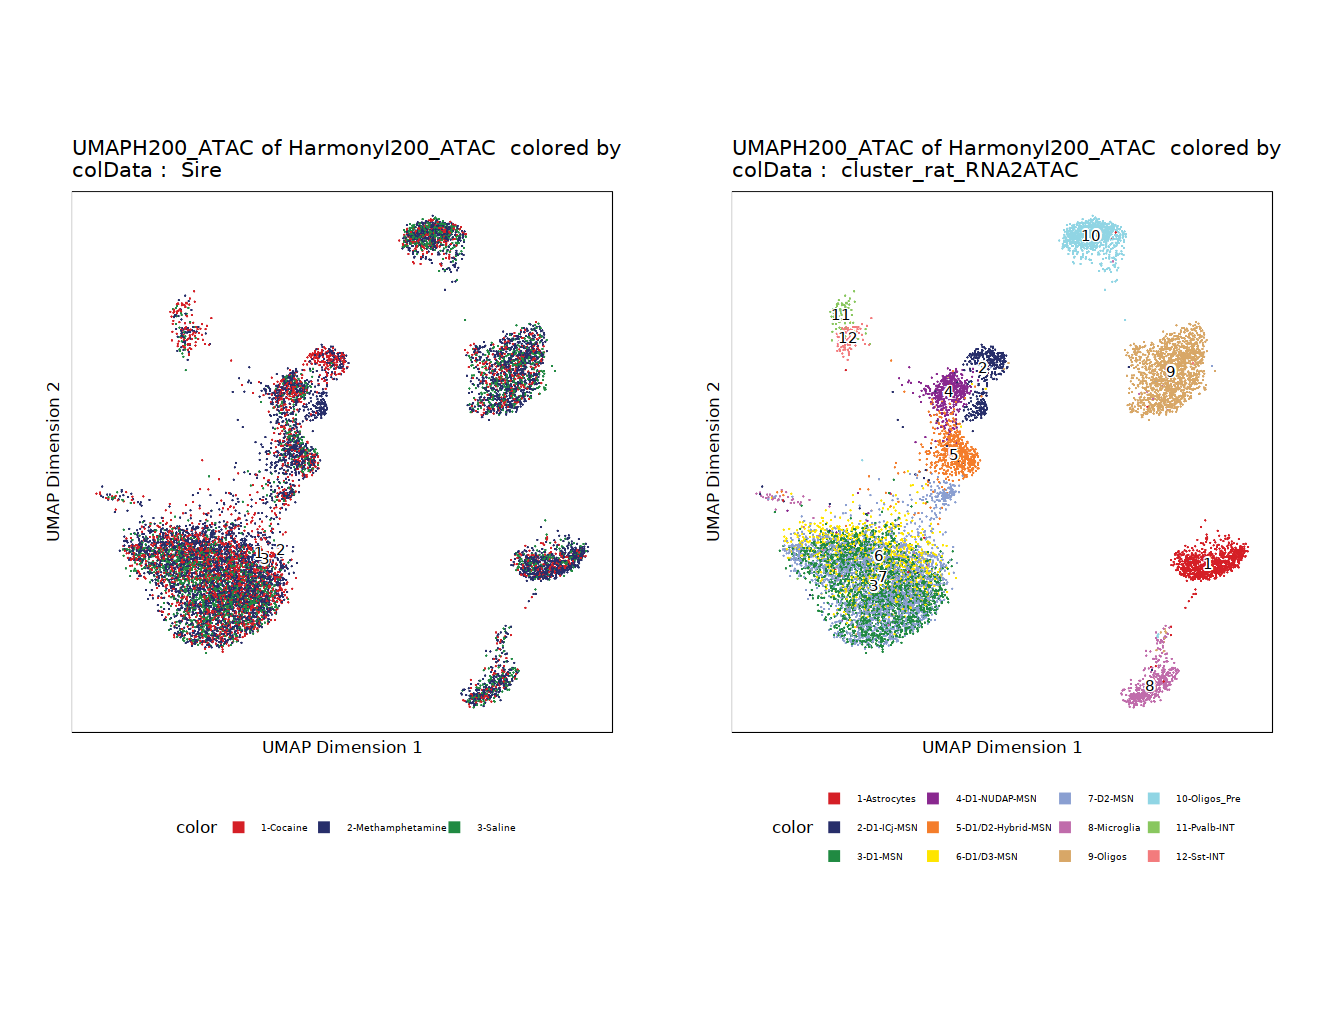

In [19]:
## make UMAP plots
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "Sire", embedding = "UMAPH200_ATAC")

p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "cluster_rat_RNA2ATAC", embedding = "UMAPH200_ATAC")

ggAlignPlots(p1, p2,  type = "h")

# Call peaks using integrated cluster_rat_RNA2ATAC

In [21]:
# make group coverage, call peaks, and 
library(BSgenome.Rnorvegicus.UCSC.rn7)
proj<-addGroupCoverages(proj, groupBy="cluster_rat_RNA2ATAC", minReplicates = 2, maxReplicates = 5, force = FALSE,
                        minCells = 40, maxCells = 1000)

Loading required package: BSgenome

Loading required package: rtracklayer

Warning message:
“replacing previous import ‘utils::download.file’ by ‘restfulr::download.file’ when loading ‘rtracklayer’”
ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-2632c5ae86c1e-Date-2022-12-05_Time-17-07-05.log
If there is an issue, please report to github with logFile!

Astrocytes (1 of 12) : CellGroups N = 4

D1-ICj-MSN (2 of 12) : CellGroups N = 3

D1-MSN (3 of 12) : CellGroups N = 5

D1-NUDAP-MSN (4 of 12) : CellGroups N = 4

D1/D2-Hybrid-MSN (5 of 12) : CellGroups N = 4

D1/D3-MSN (6 of 12) : CellGroups N = 4

D2-MSN (7 of 12) : CellGroups N = 5

Microglia (8 of 12) : CellGroups N = 4

Oligos (9 of 12) : CellGroups N = 4

Oligos_Pre (10 of 12) : CellGroups N = 5

Pvalb-INT (11 of 12) : CellGroups N = 2

Sst-INT (12 of 12) : CellGroups N = 2

2022-12-05 17:07:08 : Creating Coverage Files!, 0.051 mins elapsed.

2022-12-05 17:07:08 : Batch Execution w/ safelapply!, 0.051 mins elapsed.

2022-12-05

In [22]:
# call peaks 
proj<-addReproduciblePeakSet(proj, groupBy = "cluster_rat_RNA2ATAC", plot = FALSE, genomeSize = 2.7e9)
proj = saveArchRProject(ArchRProj = proj)

Searching For MACS2..

Found with $path!

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-2632c33d9445-Date-2022-12-05_Time-17-45-14.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-12-05 17:45:15 : Peak Calling Parameters!, 0.005 mins elapsed.



                            Group nCells nCellsUsed nReplicates nMin nMax
Astrocytes             Astrocytes    898        887           4  151  308
D1-ICj-MSN             D1-ICj-MSN    414        409           3  106  169
D1-MSN                     D1-MSN   2165       2165           5   57  654
D1-NUDAP-MSN         D1-NUDAP-MSN    495        484           4   59  160
D1/D2-Hybrid-MSN D1/D2-Hybrid-MSN    604        586           4   93  187
D1/D3-MSN               D1/D3-MSN    870        850           4  177  270
D2-MSN                     D2-MSN   2461       2461           5   74  710
Microglia               Microglia    525        524           4  115  152
Oligos                     Oligos   1416       1406           4  278  397
Oligos_Pre             Oligos_Pre    942        942           5   45  284
Pvalb-INT               Pvalb-INT     73         63           2   40   40
Sst-INT                   Sst-INT     96         96           2   47   49
                 maxPeaks
Astrocytes  

2022-12-05 17:45:17 : Batching Peak Calls!, 0.037 mins elapsed.

2022-12-05 17:45:17 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-12-05 19:08:29 : Identifying Reproducible Peaks!, 83.249 mins elapsed.

2022-12-05 19:10:32 : Creating Union Peak Set!, 85.3 mins elapsed.

Converged after 11 iterations!

2022-12-05 19:10:42 : Finished Creating Union Peak Set (466022)!, 85.464 mins elapsed.

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                

In [23]:
# add peak counts matrix 
proj <- addPeakMatrix(proj)
proj = saveArchRProject(ArchRProj = proj)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-2632c4f15ceb5-Date-2022-12-05_Time-19-10-53.log
If there is an issue, please report to github with logFile!

2022-12-05 19:10:53 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-2632c4f15ceb5-Date-2022-12-05_Time-19-10-53.log

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     |